In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score ,precision_score, recall_score, confusion_matrix
import pickle
# Import the necessary libraries
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load dataset
 # Update the path accordingly
liver_data = pd.read_csv("/content/liver_cirrhosis.csv")

In [3]:
# Check the number of duplicate rows
num_duplicates = liver_data.duplicated().sum()
print(f'Number of duplicate rows: {num_duplicates}')

# Drop the duplicate rows
df_cleaned = liver_data.drop_duplicates()

# Verify if duplicates are dropped
num_duplicates_after = df_cleaned.duplicated().sum()
print(f'Number of duplicate rows after dropping: {num_duplicates_after}')

Number of duplicate rows: 15361
Number of duplicate rows after dropping: 0


In [4]:
liver_data.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,2221,C,Placebo,18499,F,N,Y,N,N,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,9.9,1
1,1230,C,Placebo,19724,M,Y,N,Y,N,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,10.8,2
2,4184,C,Placebo,11839,F,N,N,N,N,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,10.0,2
3,2090,D,Placebo,16467,F,N,N,N,N,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,10.2,2
4,2105,D,Placebo,21699,F,N,Y,N,N,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,11.5,1


In [5]:
# Define the categorical columns to be encoded
categorical_cols = ['Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Status', 'Drug']

<ipython-input-29-74872db1ebff>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Stage', data=liver_data, palette='viridis')


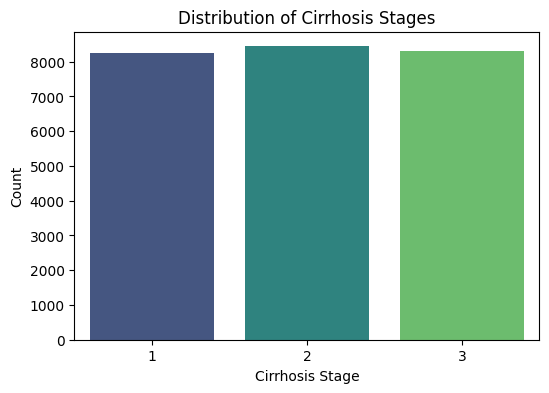

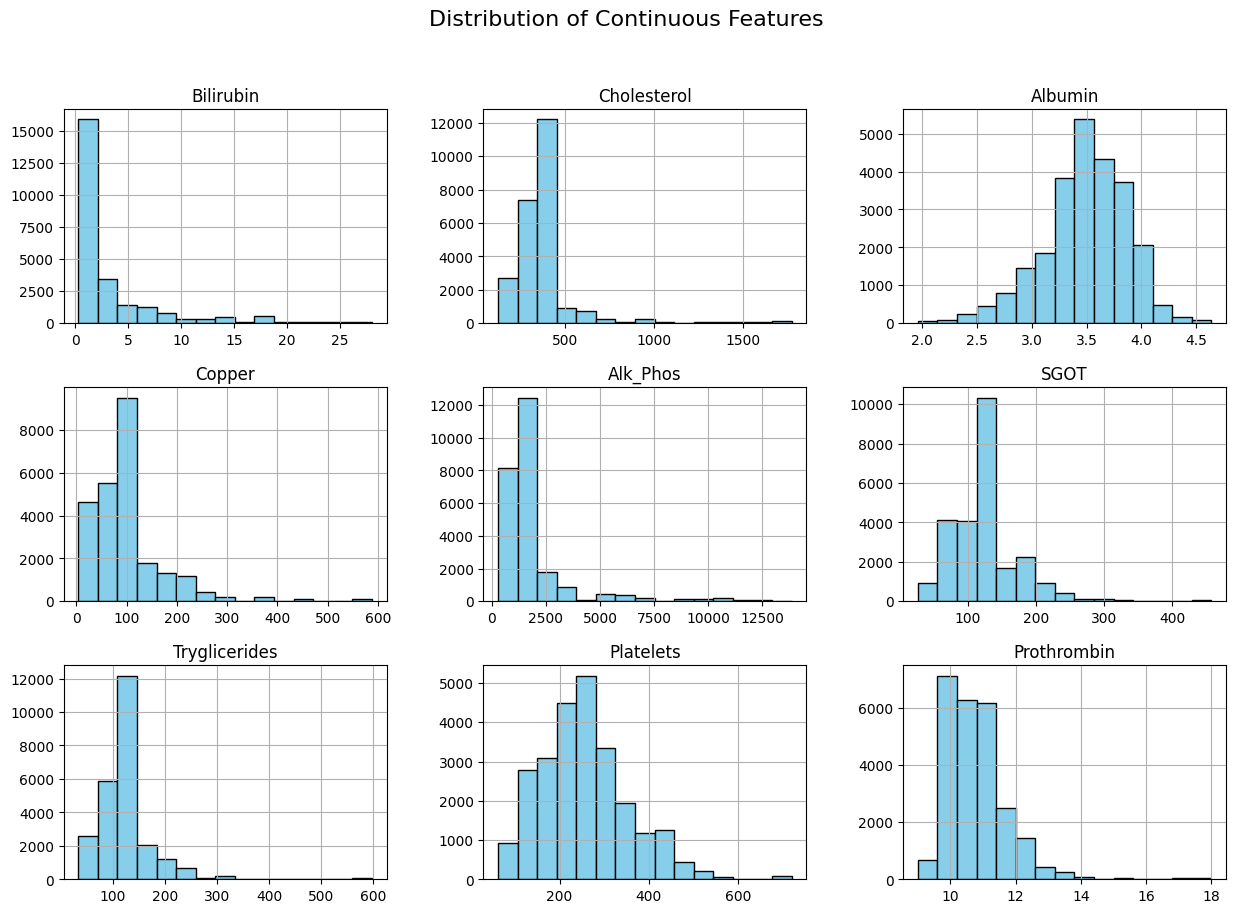

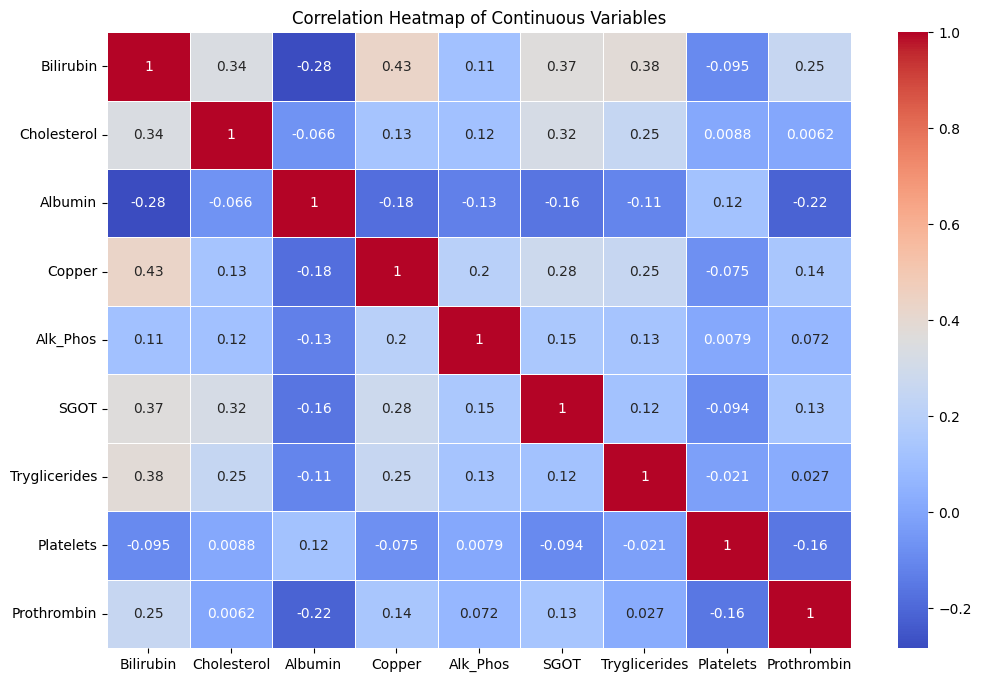

<Figure size 1200x800 with 0 Axes>

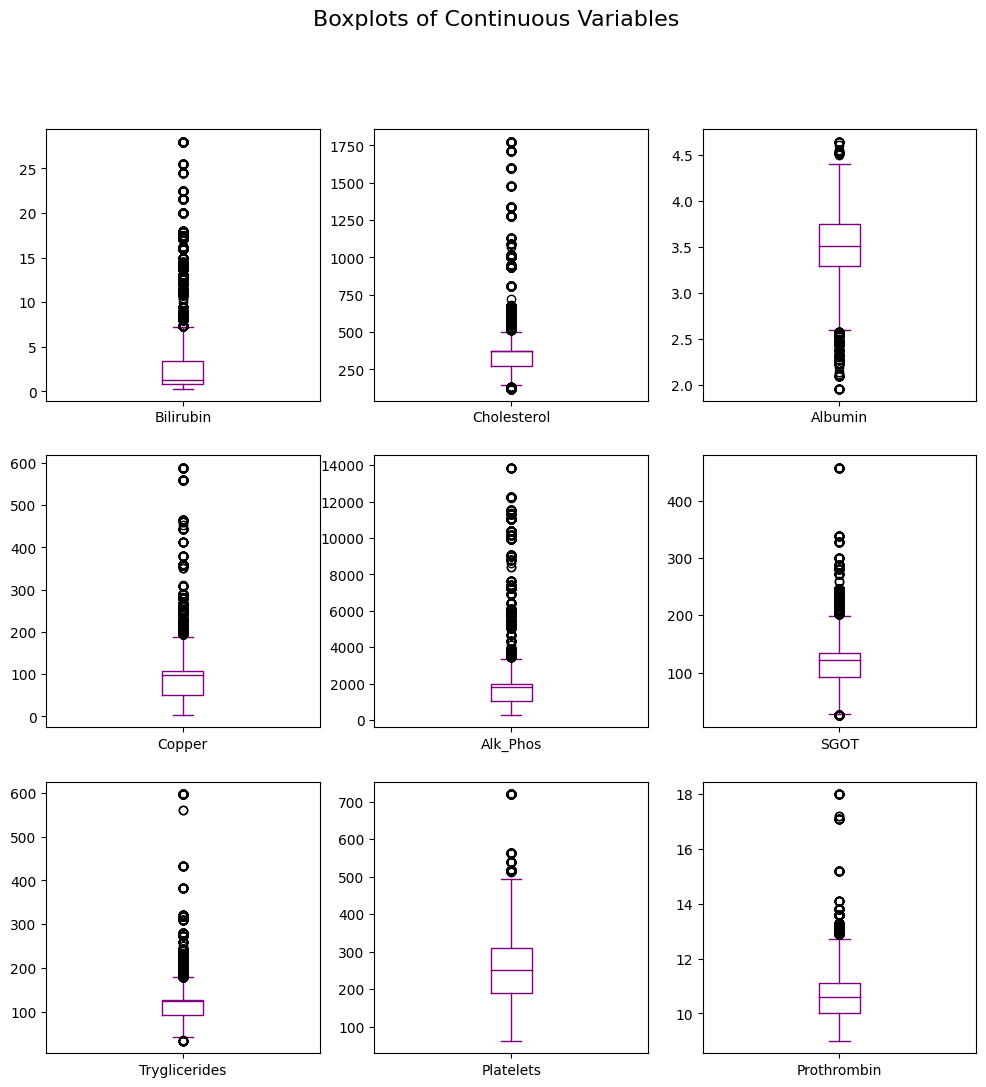

<ipython-input-29-74872db1ebff>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=liver_data, palette='Set2')
<ipython-input-29-74872db1ebff>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=liver_data, palette='Set2')
<ipython-input-29-74872db1ebff>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=liver_data, palette='Set2')
<ipython-input-29-74872db1ebff>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` a

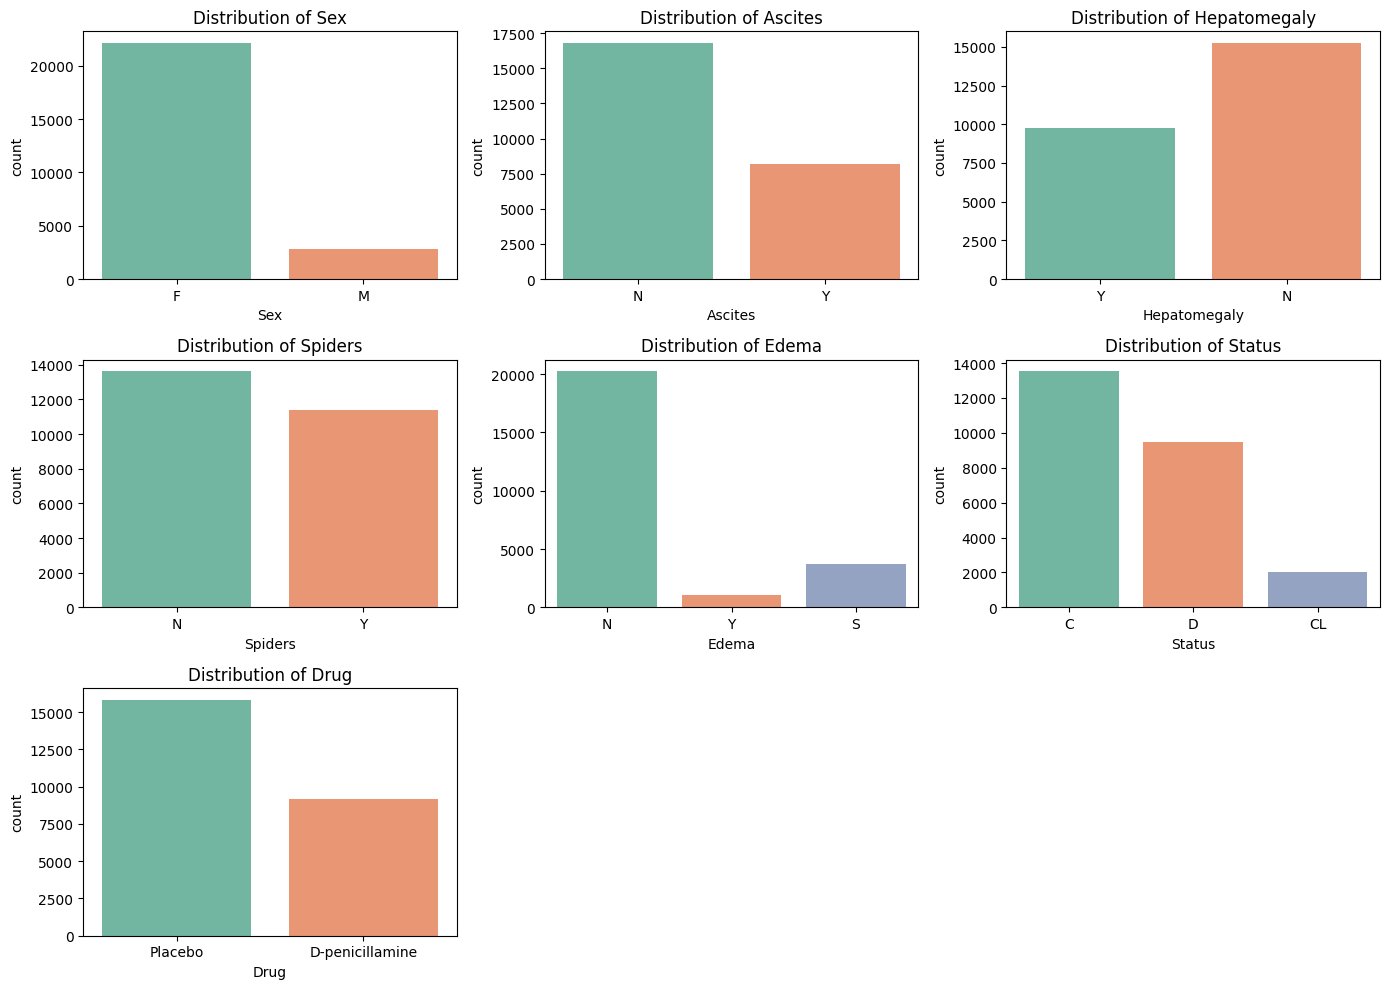

In [ ]:
# Distribution of Target Variable (Stage of Cirrhosis)
plt.figure(figsize=(6, 4))
sns.countplot(x='Stage', data=liver_data, palette='viridis')
plt.title('Distribution of Cirrhosis Stages')
plt.xlabel('Cirrhosis Stage')
plt.ylabel('Count')
plt.show()

# Distribution of Continuous Features
continuous_cols = ['Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']

# Plot histograms of continuous features
liver_data[continuous_cols].hist(figsize=(15, 10), bins=15, color='skyblue', edgecolor='black')
plt.suptitle('Distribution of Continuous Features', fontsize=16)
plt.show()

# Correlation Heatmap for Numerical Features
plt.figure(figsize=(12, 8))
corr_matrix = liver_data[continuous_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Continuous Variables')
plt.show()

# Boxplots to check for outliers in continuous features
plt.figure(figsize=(12, 8))
liver_data[continuous_cols].plot(kind='box', subplots=True, layout=(3, 3), figsize=(12, 12), sharex=False, sharey=False, color='purple')
plt.suptitle('Boxplots of Continuous Variables', fontsize=16)
plt.show()

# Categorical Variable Analysis (Sex, Ascites, Hepatomegaly, etc.)
categorical_cols = ['Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Status', 'Drug']

plt.figure(figsize=(14, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=col, data=liver_data, palette='Set2')
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
plt.show()

In [6]:
# Create a dictionary to store the fitted LabelEncoders
label_encoders = {}

# Fit the LabelEncoders on each categorical column
for col in categorical_cols:
    le = LabelEncoder()
    liver_data[col] = le.fit_transform(liver_data[col])  # Transform the column in the DataFrame
    label_encoders[col] = le  # Store the encoder in the dictionary


In [7]:
# Prepare your features (X) and target (y)
X = liver_data.drop(columns=['Stage'])
y = liver_data['Stage']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
# Train your model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [10]:
# Save the model and feature names
with open('liver_cirrhosis_model.pkl', 'wb') as f:
    pickle.dump(model, f) # Only save the model

# ---- Prediction and Evaluation ----

# Load the saved model
with open('liver_cirrhosis_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

In [11]:
# Save the label encoders to a file named label_encoders.pkl
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

In [12]:

# Load the label encoders
with open('label_encoders.pkl', 'rb') as f:
    label_encoders = pickle.load(f)

In [13]:
# Apply the same encoding to the test data
for col in categorical_cols:
    X_test[col] = X_test[col].apply(lambda x: label_encoders[col].transform([x])[0]
                                    if x in label_encoders[col].classes_ else -1)  # Handle unseen labels with -1

In [15]:
# Make predictions on the test set
y_pred = loaded_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Print classification report
report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", report)

Accuracy: 82.14%

Confusion Matrix:
 [[1486  132   39]
 [ 166 1458   73]
 [ 348  135 1163]]

Classification Report:
               precision    recall  f1-score   support

           1       0.74      0.90      0.81      1657
           2       0.85      0.86      0.85      1697
           3       0.91      0.71      0.80      1646

    accuracy                           0.82      5000
   macro avg       0.83      0.82      0.82      5000
weighted avg       0.83      0.82      0.82      5000



In [ ]:
# ---- Prediction for New Data ----

# Example new patient data (as a dictionary)
new_patient_data = {
    'N_Days': 1149,           # Example number of days
    'Status': 'C',          # Survival status
    'Drug': 'Placebo',      # Drug type
    'Age': 11167,            # Age in days
    'Sex': 'M',             # Gender
    'Ascites': 'N',         # Ascites condition
    'Hepatomegaly': 'N',    # Hepatomegaly condition
    'Spiders': 'N',         # Spiders condition
    'Edema': 'N',           # Edema condition
    'Bilirubin': 0.8,      # Lab values
    'Cholesterol': 271,
    'Albumin': 3.56,
    'Copper': 52,
    'Alk_Phos': 955,
    'SGOT': 130,
    'Tryglicerides': 177,
    'Platelets': 344,
    'Prothrombin': 10.5
}

# Convert the new data into a DataFrame
new_data_df = pd.DataFrame([new_patient_data])

# Apply the same label encoders to the new data and handle unseen labels
for col in categorical_cols:
    new_data_df[col] = new_data_df[col].apply(lambda x: label_encoders[col].transform([x])[0]
                                              if x in label_encoders[col].classes_ else -1)  # Handle unseen labels with -1

# Make predictions on the new patient data
new_patient_prediction = loaded_model.predict(new_data_df)

# Print the predicted stage for the new patient
print(f"The predicted cirrhosis stage for the new patient is: {new_patient_prediction[0]}")

The predicted cirrhosis stage for the new patient is: 1


In [ ]:
import pickle

# Load the saved model
with open('liver_cirrhosis_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Load the saved label encoders
with open('label_encoders.pkl', 'rb') as f:
    label_encoders = pickle.load(f)

print("Model and encoders loaded successfully!")



Model and encoders loaded successfully!


In [ ]:
from google.colab import files

# Download the model and label encoders
files.download('liver_cirrhosis_model.pkl')
files.download('label_encoders.pkl')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>